# Conceptual Design

### Demo 2D structure

Exploration of use of Python/Jupyter to analyze and visualize structures discussed in Hervé Capart's _Conceptual Design_ class at NTU Civil Engineering.

# Preliminaries

In [49]:
import os
from cdsn.mesh import Mesh
from cdsn.graph import Graph
from cdsn.communities import Communities
from cdsn.geometry import Geometry
from cdsn.forces import Forces
from cdsn.plot import Visualization
from cdsn.save import create_directories, export_plots

# Analysis

In [50]:
name = "simpleStructure1"
# name = "standingTower1"

In [51]:
mesh = Mesh(name)
mesh.file_path_name, mesh.trimesh

('../Data/STL/simpleStructure1.stl',
 <trimesh.Trimesh(vertices.shape=(18, 3), faces.shape=(14, 3))>)

In [52]:
graph = Graph(mesh)
graph.nxgraph, graph.n_triangles

(<networkx.classes.graph.Graph at 0x17d8f2fb0>, 14)

In [53]:
communities = Communities(graph)
communities.n_communities, #communities.d_community_nodes

(4,)

In [54]:
geometry = Geometry(communities)

In [55]:
geometry.d_keynode_appliedload

{7: 0}

In [56]:
geometry.d_member_appliedloads

{0: frozenset({0}), 1: frozenset()}

In [57]:
forces = Forces(geometry)

In [58]:
forces.d_appliedload_forcevector

{0: array([ 0., -1.,  0.])}

# Visualization

To view these structures in 3D online, go to:
   - [Simple structure #1](https://htmlpreview.github.io/?https://github.com/cstarkjp/ConceptualDesign/blob/main/Plots/simpleStructure1.html)
   - [Standing tower #1](https://htmlpreview.github.io/?https://github.com/cstarkjp/ConceptualDesign/blob/main/Plots/standingTower1.html)

In [59]:
viz = Visualization(font_name="Arial")

Need to cross-ref applied load triangles to actual graph and pvmesh triangles – if we want to label the load triangles in 3D.

In [60]:
pvmesh = viz.build_mesh(geometry)

In [66]:
graph.d_trinodes_triangles

{frozenset({0, 1, 2}): 0,
 frozenset({0, 1, 5}): 1,
 frozenset({0, 3, 4}): 2,
 frozenset({0, 3, 5}): 3,
 frozenset({3, 5, 8}): 4,
 frozenset({5, 7, 8}): 5,
 frozenset({6, 7, 8}): 6,
 frozenset({4, 10, 15}): 7,
 frozenset({4, 12, 13}): 8,
 frozenset({4, 13, 15}): 9,
 frozenset({12, 13, 14}): 10,
 frozenset({2, 9, 10}): 11,
 frozenset({2, 9, 11}): 12,
 frozenset({7, 16, 17}): 13}

In [62]:
communities.d_community_triangles

{0: frozenset({frozenset({0, 3, 4}),
            frozenset({3, 5, 8}),
            frozenset({0, 1, 2}),
            frozenset({5, 7, 8}),
            frozenset({6, 7, 8}),
            frozenset({0, 1, 5}),
            frozenset({0, 3, 5})}),
 1: frozenset({frozenset({2, 9, 10}), frozenset({2, 9, 11})}),
 2: frozenset({frozenset({12, 13, 14}),
            frozenset({4, 12, 13}),
            frozenset({4, 13, 15}),
            frozenset({4, 10, 15})}),
 3: frozenset({frozenset({7, 16, 17})})}

In [63]:
geometry.d_member_community

{0: 0, 1: 1}

In [64]:
plotter = viz.plot_model_3d(
    pvmesh, 
    geometry=geometry,
    backend="trame", 
    do_appliedload_labels=True,
)

Widget(value="<iframe src='http://localhost:59428/index.html?ui=P_0x17d8f2110_2&reconnect=auto' style='width: …

TypeError: 'frozenset' object is not subscriptable

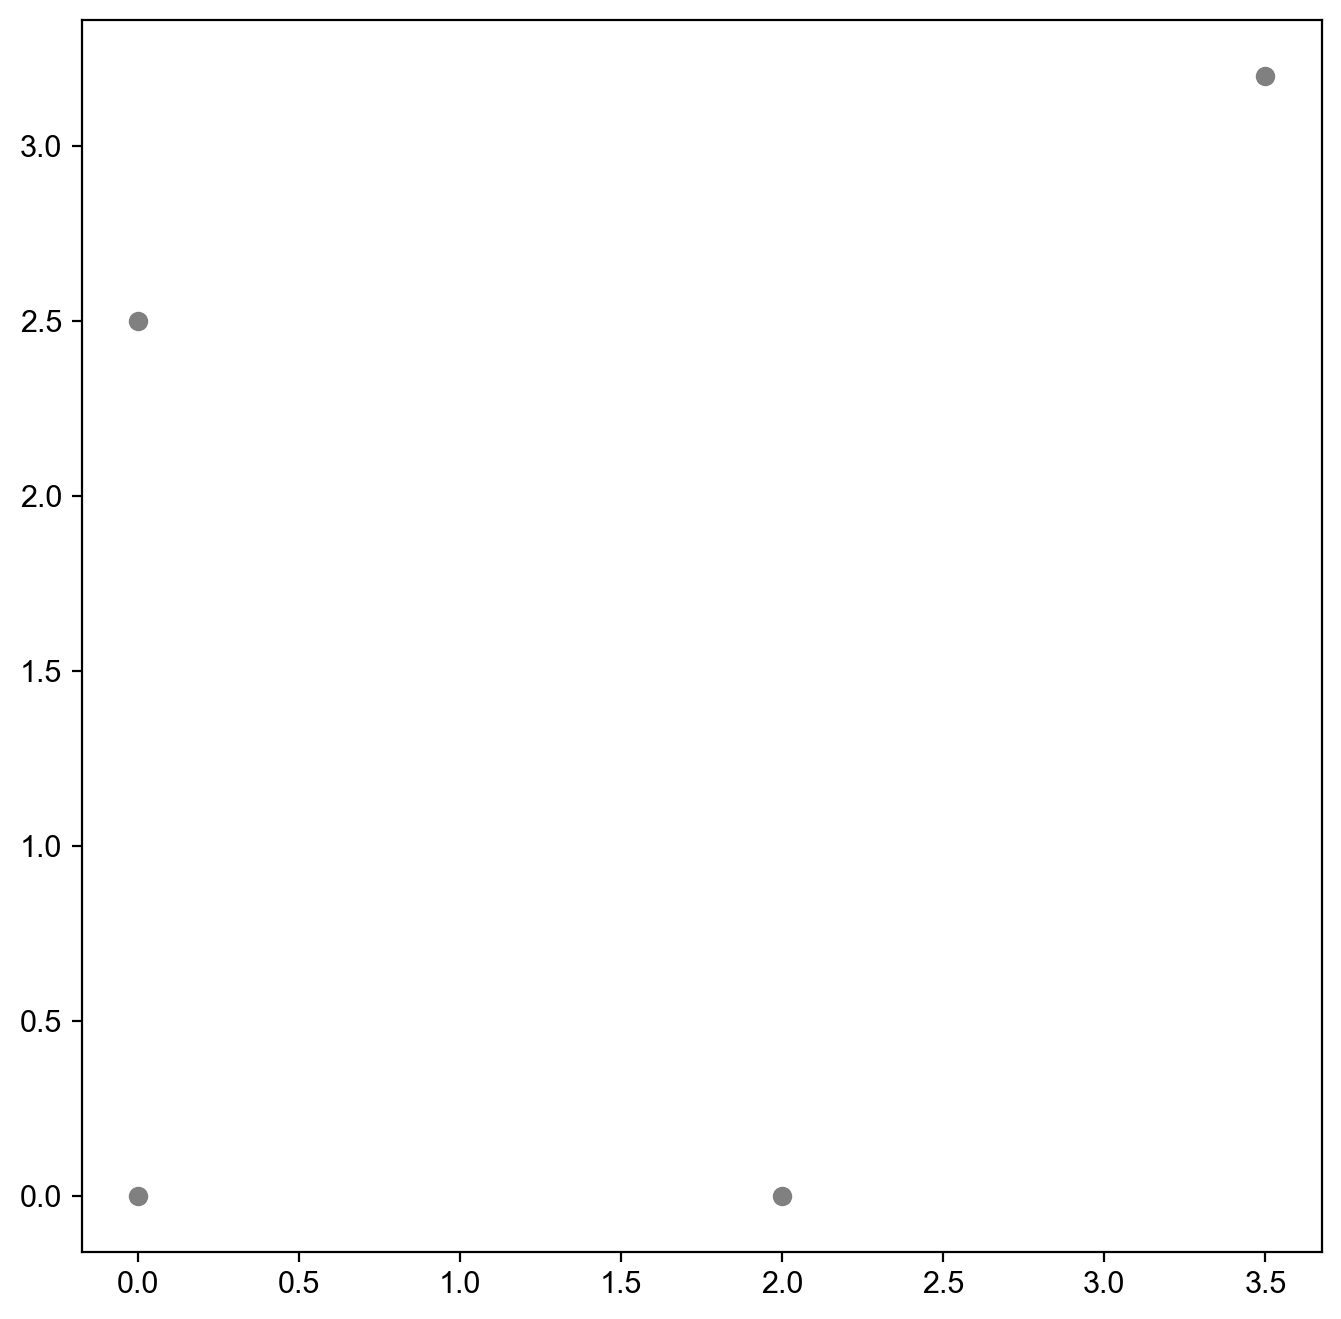

In [65]:
viz.plot_model(name, graph, communities, geometry)

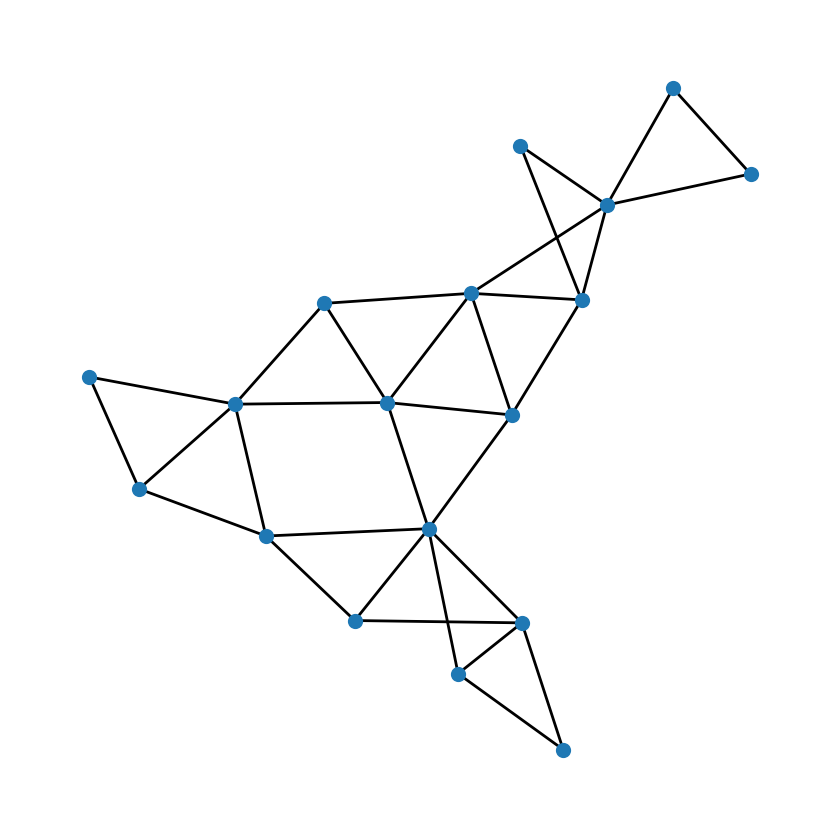

In [ ]:
viz.plot_graph(name, graph, fig_size=(4,4,),)

# Export

In [ ]:
plots_dirname = "Plots"
plots_path = create_directories(("..",), plots_dirname)
for gr_ in [viz]:    
    export_plots( gr_.fdict, plots_path, file_types=["jpg"], dpi=100 )

In [ ]:
plotter.export_html(os.path.join(plots_path, f"{name}.html"))